# GM-VAE for SMBA

In [1]:
num_components=6

## Import Libraries

In [5]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

from model.GMVAE import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load data

In [6]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

Load SMB.

In [7]:
smb_int = open_json_as_nparray('smbWithPath-allLevels-chunks-int.json')

In [8]:
smb_onehot = np.eye(len(np.unique(smb_int)))[smb_int]
smb_onehot.shape

(2698, 16, 16, 12)

In [9]:
smb_onehot = smb_onehot.reshape(
    smb_onehot.shape[0], 
    smb_onehot.shape[1] * smb_onehot.shape[2] * smb_onehot.shape[3]
)
smb_onehot.shape

(2698, 3072)

In [10]:
np.random.seed(42)
smb_labels = np.random.randint(num_components, size=smb_onehot.shape[0])
smb_labels.shape, smb_labels[:20]

((2698,), array([3, 4, 2, 4, 4, 1, 2, 2, 2, 4, 3, 2, 5, 4, 1, 3, 5, 5, 1, 3]))

In [11]:
chunks, labels = smb_onehot, smb_labels

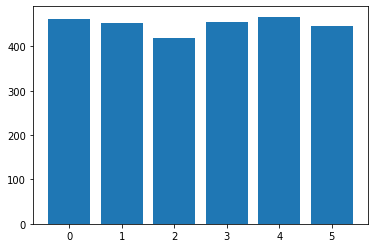

In [12]:
plt.bar(np.arange(num_components), np.bincount(smb_labels))
plt.show()

## Input Parameters

In [13]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=100,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=num_components,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=3072, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [14]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [15]:
from torch.utils.data import TensorDataset, DataLoader

In [16]:
assert args.train_proportion != 1

In [17]:
def partition_dataset(n, proportion=1):
   train_num = int(n * proportion)
   indices = np.random.permutation(n)
   train_indices, val_indices = indices[:train_num], indices[train_num:]
   return train_indices, val_indices

train_indices, val_indices = partition_dataset(len(chunks), args.train_proportion)
train_ds = TensorDataset(torch.from_numpy(chunks).float(), torch.from_numpy(labels).long())
train_dl = DataLoader(train_ds, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
valid_dl = DataLoader(train_ds, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))

## Train Model

In [18]:
# Model Initialization
gmvae = GMVAE(args)

In [16]:
history_loss = gmvae.train(train_dl, valid_dl)

(Epoch 1 / 100) Train_Loss: 491.536; Val_Loss: 238.306   Train_ACC: 18.410; Val_ACC: 22.222   Train_NMI: 0.262; Val_NMI: 0.935
(Epoch 2 / 100) Train_Loss: 229.958; Val_Loss: 234.162   Train_ACC: 18.410; Val_ACC: 21.111   Train_NMI: 0.188; Val_NMI: 0.837
(Epoch 3 / 100) Train_Loss: 227.006; Val_Loss: 229.272   Train_ACC: 18.699; Val_ACC: 20.741   Train_NMI: 0.252; Val_NMI: 1.531
(Epoch 4 / 100) Train_Loss: 223.804; Val_Loss: 222.221   Train_ACC: 18.493; Val_ACC: 20.370   Train_NMI: 0.296; Val_NMI: 1.064
(Epoch 5 / 100) Train_Loss: 216.600; Val_Loss: 215.216   Train_ACC: 18.451; Val_ACC: 21.481   Train_NMI: 0.301; Val_NMI: 3.301
(Epoch 6 / 100) Train_Loss: 212.550; Val_Loss: 210.391   Train_ACC: 18.410; Val_ACC: 20.741   Train_NMI: 0.400; Val_NMI: 1.349
(Epoch 7 / 100) Train_Loss: 208.580; Val_Loss: 204.247   Train_ACC: 18.163; Val_ACC: 20.741   Train_NMI: 0.478; Val_NMI: 1.652
(Epoch 8 / 100) Train_Loss: 204.508; Val_Loss: 214.582   Train_ACC: 19.069; Val_ACC: 25.185   Train_NMI: 0.402;

(Epoch 66 / 100) Train_Loss: 130.492; Val_Loss: 157.475   Train_ACC: 18.493; Val_ACC: 23.704   Train_NMI: 0.275; Val_NMI: 4.097
(Epoch 67 / 100) Train_Loss: 129.317; Val_Loss: 160.098   Train_ACC: 18.699; Val_ACC: 22.593   Train_NMI: 0.368; Val_NMI: 3.421
(Epoch 68 / 100) Train_Loss: 128.895; Val_Loss: 156.280   Train_ACC: 18.863; Val_ACC: 24.444   Train_NMI: 0.405; Val_NMI: 3.956
(Epoch 69 / 100) Train_Loss: 128.176; Val_Loss: 153.532   Train_ACC: 18.657; Val_ACC: 23.333   Train_NMI: 0.327; Val_NMI: 2.830
(Epoch 70 / 100) Train_Loss: 127.473; Val_Loss: 162.868   Train_ACC: 19.110; Val_ACC: 23.704   Train_NMI: 0.420; Val_NMI: 2.971
(Epoch 71 / 100) Train_Loss: 126.848; Val_Loss: 160.276   Train_ACC: 18.740; Val_ACC: 23.333   Train_NMI: 0.428; Val_NMI: 3.802
(Epoch 72 / 100) Train_Loss: 125.882; Val_Loss: 158.601   Train_ACC: 19.110; Val_ACC: 23.333   Train_NMI: 0.429; Val_NMI: 3.178
(Epoch 73 / 100) Train_Loss: 125.114; Val_Loss: 160.643   Train_ACC: 19.028; Val_ACC: 23.704   Train_NMI

In [17]:
torch.save(gmvae.network.state_dict(), 'smba_gmvae.pth')

In [19]:
gmvae.network.load_state_dict(torch.load('smba_gmvae.pth'))

<All keys matched successfully>

## Image Reconstruction

In [19]:
original, reconstructed = gmvae.reconstruct_data(train_dl, 15)  

In [20]:
original_int = original.reshape(15, 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(15, 16, 16, 12).argmax(axis=-1)

In [21]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [22]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [23]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [24]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

(15, 15)

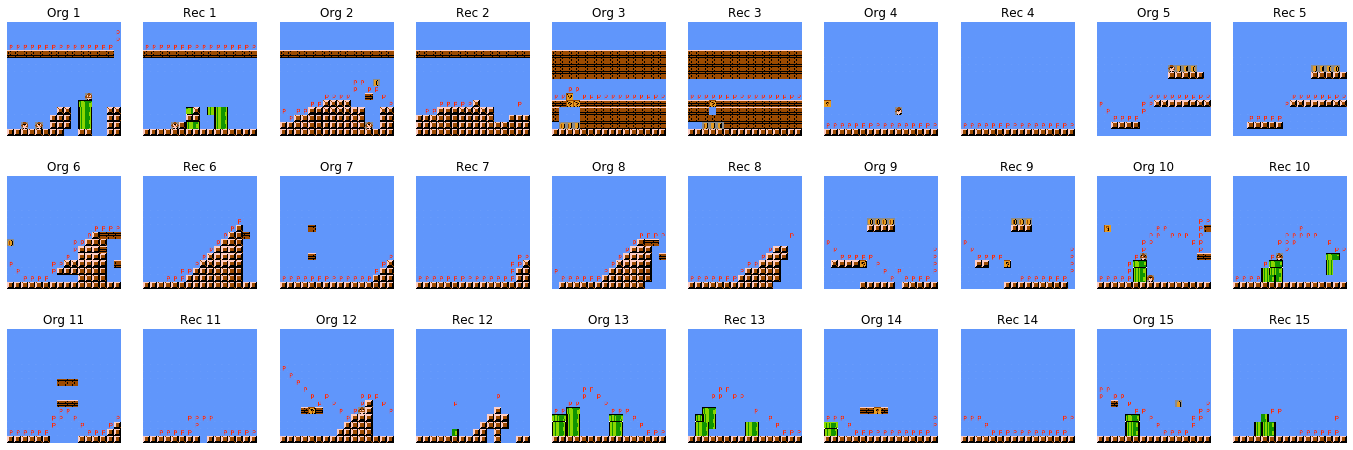

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

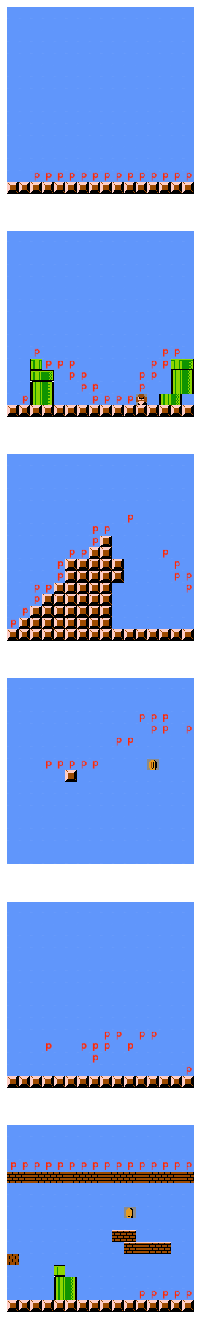

In [26]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,24])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 1
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [27]:
elem_per_category = 10000 // num_components
generated = gmvae.random_generation(elem_per_category)

In [28]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [29]:
generated_int.shape

(9996, 16, 16)

In [30]:
# since this code chunk depends on random seed, it shouldn't be run again
with open(f'../smba_generations_2_to_7/smba_gmvae_{num_components}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of the feature latent space

In [21]:
# get feature representations
test_features, test_labels = gmvae.latent_features(train_dl, return_learned_labels=True)

In [24]:
np.bincount(test_labels)

array([560, 460, 366, 364, 384, 294])

In [32]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

first_n = 1000
tsne_features = TSNE(n_components=2).fit_transform(test_features[:first_n])

In [33]:
test_labels_subset = test_labels[:first_n]

In [34]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

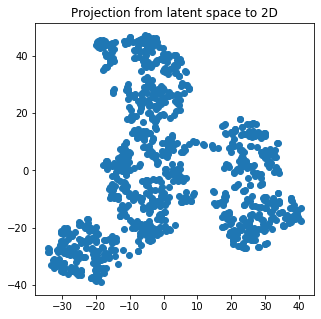

In [35]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(tsne_features[X_], tsne_features[Y_])

plt.title('Projection from latent space to 2D')
plt.show()